In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tensorflow.keras import models, layers, regularizers

In [2]:
config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)

config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  1


In [3]:
data = np.load('Datasets/Apple_.npy', allow_pickle= True)
#data_test = np.load('Datasets/Apple_labels.npy', allow_pickle= True)

labels = np.load('Datasets/Apple_labels.npy', allow_pickle= True)
#test_labels = np.load('Datasets/test_labels.npy', allow_pickle= True)

data.shape, labels.shape

((360, 300, 32, 32), (360,))

In [4]:
data = np.transpose(data, (0, 2, 3, 1))  # (height, width, depth, channels)

data.shape

(360, 32, 32, 300)

In [5]:
mean = data.mean(axis=(0, 1, 2), keepdims=True)
std_dev = data.std(axis=(0, 1, 2), keepdims=True)

# Z-score normalization
data = (data - mean) / std_dev

print("Dataset shape:", data.shape)

Dataset shape: (360, 32, 32, 300)


In [6]:
# Split data into training, validation, and testing sets
data_train, data_test, train_labels, test_labels = train_test_split(data, labels, test_size = 0.25, random_state = 42, stratify = labels)

data_train.shape, train_labels.shape, data_test.shape, test_labels.shape

((270, 32, 32, 300), (270,), (90, 32, 32, 300), (90,))

In [7]:
# Simulated HSI data
hsi_image_train = data_train
hsi_image_test = data_test

# Reshape to (264 * 1024, 320)
hsi_reshaped_train = hsi_image_train.reshape(-1, 300)
hsi_reshaped_test = hsi_image_test.reshape(-1, 300)

hsi_reshaped_train.shape, hsi_reshaped_test.shape

((276480, 300), (92160, 300))

In [8]:
# Apply PCA
pca = PCA()
hsi_train_pca = pca.fit_transform(hsi_reshaped_train)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

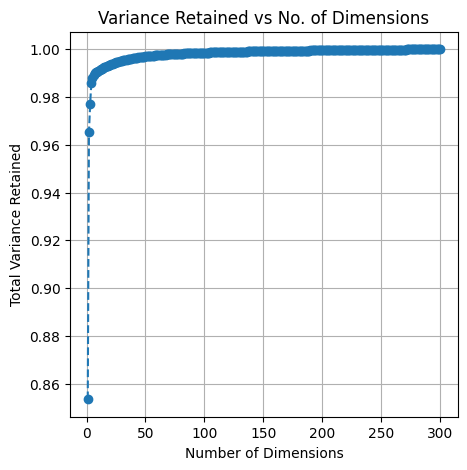

In [9]:
plt.figure(figsize=(5, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Dimensions')
plt.ylabel('Total Variance Retained')
plt.title('Variance Retained vs No. of Dimensions')
plt.grid()
plt.show()

In [10]:
#No. of Dimensions that retains 95% varinace:
optimal_components = np.argmax(cumulative_explained_variance >= 0.999) + 1 
print(f"Number of Dimensions to retain 99% variance: {optimal_components}")

pca = PCA(n_components=optimal_components)

X_train_PCA = pca.fit_transform(hsi_reshaped_train)
X_test_pca = pca.transform(hsi_reshaped_test)

X_train_PCA.shape, X_test_pca.shape

Number of Dimensions to retain 99% variance: 133


((276480, 133), (92160, 133))

In [11]:
# Reshape back to the spatial dimensions
data_train = X_train_PCA.reshape(270, 32, 32, optimal_components)
data_test = X_test_pca.reshape(90, 32, 32, optimal_components)

data_train.shape, data_test.shape

((270, 32, 32, 133), (90, 32, 32, 133))

In [12]:
le= LabelEncoder()
y_train = le.fit_transform(train_labels)

le2= LabelEncoder()
y_test= le2.fit_transform(test_labels)

In [13]:
# Add channel dimension to data
data_train = data_train[..., np.newaxis]
data_test = data_test[..., np.newaxis]

data_train.shape, data_test.shape

((270, 32, 32, 133, 1), (90, 32, 32, 133, 1))

In [14]:
def augment_data(sample, label):
    
    # Random flip along different axes
    sample = tf.image.random_flip_left_right(sample)
    sample = tf.image.random_flip_up_down(sample)

    # Random rotation
    sample = tf.image.rot90(sample, k=np.random.randint(1, 4))  # k=1 to 3 random rotations of 90°

    # Random intensity scaling (brightness variation)
    sample = sample * tf.random.uniform([], 0.9, 1.1)  # Random scale between 0.9 and 1.1
    
    return sample, label

In [15]:
# Convert data to TensorFlow dataset

train_dataset = tf.data.Dataset.from_tensor_slices((data_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((data_test, y_test))

# Apply augmentation only on training data
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch
batch_size = 8

train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
'''
tf.random.set_seed(1234)

# Define the model architecture as in the previous answer
input_shape = (32, 32, 199, 1)

model = models.Sequential([
    layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu', input_shape=input_shape),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    
    layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu'),
    layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu'),
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.summary()
'''

tf.random.set_seed(1234)

input_shape = (32, 32, optimal_components, 1)

model = models.Sequential([
    
    layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),
    
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    
    #layers.Dropout(0.3),  # Dropout with a rate of 0.3

    layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    
    layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1, 1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.0001)),
    
    layers.AveragePooling3D(pool_size=(2, 2, 2)),
    
    #layers.Dropout(0.3),  # Dropout with a rate of 0.3

    layers.Flatten(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout with a rate of 0.5
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 30, 131, 32)   896       
                                                                 
 average_pooling3d_2 (Averag  (None, 15, 15, 65, 32)   0         
 ePooling3D)                                                     
                                                                 
 conv3d_4 (Conv3D)           (None, 13, 13, 63, 64)    55360     
                                                                 
 conv3d_5 (Conv3D)           (None, 11, 11, 61, 128)   221312    
                                                                 
 average_pooling3d_3 (Averag  (None, 5, 5, 30, 128)    0         
 ePooling3D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 96000)            

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

'''
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor = 'loss',
                            patience = 5,
                            restore_best_weights = True
                        )
                    ])

'''
# Define the callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'best_model_apple.h5',            # Path to save the best model
    monitor = 'accuracy',                   # Metric to monitor
    save_best_only = True,                 # Save only the best model
    save_weights_only = False,             # Save the entire model (architecture + weights)
    mode = 'max',                          # Mode 'max' because we want to maximize accuracy
    verbose = 1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss',
    patience = 15,
    restore_best_weights = True
)

# Train the model with the callbacks
history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = test_dataset,
    callbacks = [checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 1.7980 - accuracy: 0.2926
Epoch 1: accuracy improved from -inf to 0.29259, saving model to best_model_apple.h5
34/34 [==============================] - 14s 310ms/step - loss: 1.7980 - accuracy: 0.2926 - val_loss: 1.6940 - val_accuracy: 0.3333
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 1.6957 - accuracy: 0.3370
Epoch 2: accuracy improved from 0.29259 to 0.33704, saving model to best_model_apple.h5
34/34 [==============================] - 4s 110ms/step - loss: 1.6957 - accuracy: 0.3370 - val_loss: 1.6455 - val_accuracy: 0.3333
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 1.6560 - accuracy: 0.3074
Epoch 3: accuracy did not improve from 0.33704
34/34 [==============================] - 4s 104ms/step - loss: 1.6560 - accuracy: 0.3074 - val_loss: 1.6509 - val_accuracy: 0.3333
Epoch 4/100
34/34 [==============================] - ETA: 0s - loss: 1.6450 - accuracy: 0.3333
Epoch 

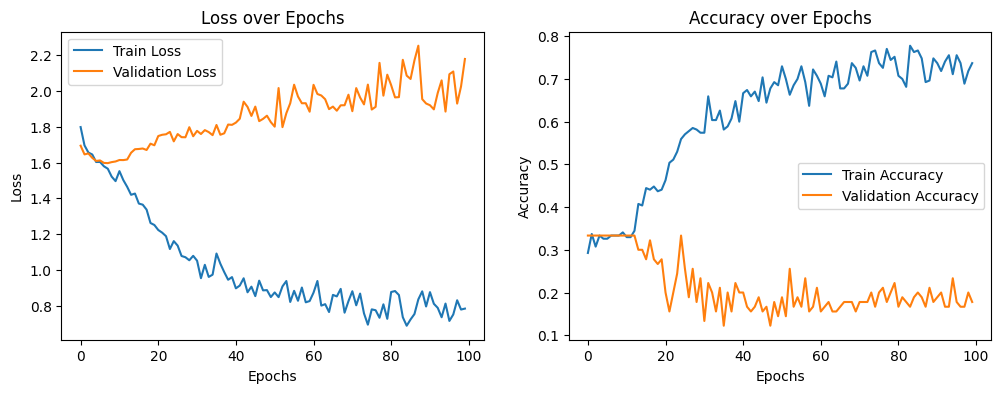

In [20]:
# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
# Get true labels and predictions
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = np.argmax(model.predict(test_dataset), axis=-1)

12/12 [==============================] - 0s 27ms/step


In [22]:
# Classification report
print("Classification Report:")
print(classification_report(test_labels, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.19      1.00      0.31        15
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        15
           4       0.22      0.13      0.17        15

    accuracy                           0.19        90
   macro avg       0.08      0.23      0.10        90
weighted avg       0.07      0.19      0.08        90



c:\Users\rafin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rafin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rafin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

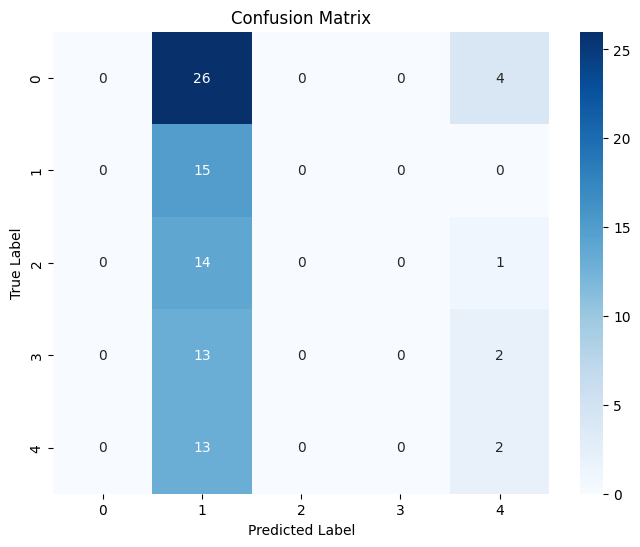

In [25]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(5)], yticklabels=[str(i) for i in range(5)])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()